<center>
    <h1>Cloud Movement Diffusion</h1>
    <h2>Artificial Intelligence in Industry</h2>
    <h3>Facundo Nicolas Maidana, Farshid Mahmoudabadi, and Riccardo Spolaor</h3>
    <h4>riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This project explores the use of diffusion models for short-term solar energy forecasting. Diffusion models are a type of generative model that can be used to predict the future state of a system by gradually "diffusing" from the current state. In this project, we train a diffusion model on a dataset of cloud images. We then use the model to predict the future state of the clouds, which can be used to forecast solar energy production.

Introduction:

Solar energy is a promising renewable energy source, but it is intermittent. This means that the amount of solar energy produced can vary significantly from day to day. Short-term solar energy forecasting can help to mitigate this variability by providing estimates of solar energy production in the near future.

Diffusion models:

Diffusion models are a type of generative model that can be used to predict the future state of a system by gradually "diffusing" from the current state. Diffusion models are trained on a dataset of images, and they can be used to generate new images that are similar to the images in the dataset.

Project goals:

The goals of this project are to:

Train a diffusion model on a dataset of cloud images.
Use the model to predict the future state of the clouds.
Use the predicted cloud state to forecast solar energy production.

Project results:

The results of this project show that diffusion models can be used to predict the future state of the clouds with some accuracy. The predicted cloud state can then be used to forecast solar energy production.

# Settings

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
from types import SimpleNamespace

# TODO: Some of these parameters are not used, remove them.
config = SimpleNamespace(
    epochs=201, # Number of epochs.
    model_name='unet_small', # Model name to save [unet_small, unet_big].
    strategy='ddpm', # Strategy to use ddpm.
    noise_steps=1_000, # Number of noise steps on the diffusion process.
    sampler_steps=333, # Number of sampler steps on the diffusion process.
    seed=42, # Random seed.
    batch_size=128, # Batch size.
    img_size=64, # Image size.
    device='cuda', # Device to use.
    num_workers=0, # Number of workers for dataloader.
    num_input_frames=3, # Number of frames to use as input for the training.
    lr=2e-3, # Learning rate.
    log_every_epoch=5, # Log every n epochs to wandb.
    num_prediction_frames=3, # Number of predictions to make.
    num_channels=1, # Number of channels.
    validate_epochs=False, # Whether to validate every epoch.
    )

# Dataset

In [4]:
import wandb
wandb.login()

wandb: Currently logged in as: maidacundo (arked). Use `wandb login --relogin` to force relogin


True

## Dataset class

## training

In [6]:
PROJECT_NAME = 'sevir'
DATASET_ARTIFACT = 'ai-industry/sevir/SEVIR:latest'
SCALERS_ARTIFACT = 'ai-industry/sevir/scalers:latest'

In [7]:
import torch

from src.seeder import set_seed
from src.model import get_unet_params
from src.dataset_builder import download_dataset, download_scalers
from src.scaler import Scaler

# Set the model parameters in the config file.
'''config.model_params = get_unet_params(
    model_name=config.model_name,
    num_frames=10)''';

# Set the model parameters in the config file.
# TODO: base num_frames on config
config.model_params = get_unet_params(
    model_name=config.model_name,
    num_input_frames=config.num_input_frames + config.num_prediction_frames,
    num_output_frames=config.num_prediction_frames,
    num_channels=config.num_channels
    )

# Set the seed and device.
set_seed(config.seed)
device = torch.device(config.device)

# Downlaod the dataset from the wandb Artifact.
files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)
scalers = download_scalers(SCALERS_ARTIFACT, PROJECT_NAME)

wandb: Downloading large artifact SEVIR:latest, 8544.38MB. 9 files... 
wandb:   9 of 9 files downloaded.  
Done. 0:0:3.2


wandb:   3 of 3 files downloaded.  


In [8]:
from src.dataset_builder import CloudDataset

# Build the train and validation datasets.
train_ds = CloudDataset(
    files=files[1:2], # Use just ir069 training images.
    num_frames=config.num_input_frames + config.num_prediction_frames, # Use 3 frames as input and 3 frames as prediction.
    img_size=config.img_size, # Image size.
    scalers=scalers[0:1] # Use just ir069 scaler.
    ).shuffle()
valid_ds = CloudDataset(
    files=files[2:3], # Use just ir069 validation images.
    num_frames=config.num_input_frames + config.num_prediction_frames, # Use 3 frames as input and 3 frames as prediction.
    img_size=config.img_size, # Image size.
    scalers=scalers[0:1]) # Use just ir069 scaler.

In [9]:
from src.dataloader import NoisifyDataloader, ValidationDataloader
from src.model import UNet2D
from src.sampler import ddim_sampler
from src.training import MiniTrainer

# Build the DDPM noise train and validation dataloaders.
train_dataloader = NoisifyDataloader(
    train_ds,
    config.batch_size,
    shuffle=True,
    n_frames_to_nosify=config.num_prediction_frames,
    num_workers=config.num_workers)

valid_dataloader = ValidationDataloader(
    valid_ds,
    config.batch_size,
    n_past_frames=config.num_input_frames,
    shuffle=False,
    num_workers=config.num_workers)

# Setup the model.
model = UNet2D(**config.model_params)

# Setup the sampler.
sampler = ddim_sampler(
    steps=config.sampler_steps,
    n_frames_to_predict=config.num_prediction_frames,
    n_channels=config.num_channels)

# Get the trainer.
trainer = MiniTrainer(
    train_dataloader,
    valid_dataloader,
    model,
    sampler,
    scalers[0],
    device,
    n_frames_to_predict=config.num_prediction_frames,
    n_auto_regression_steps=None)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


wandb: Currently logged in as: maidacundo (ai-industry). Use `wandb login --relogin` to force relogin


validation epoch=0, val PSNR=-3.462, val SSIM=0.001, val MSE=0.508, val mCSI=0.740


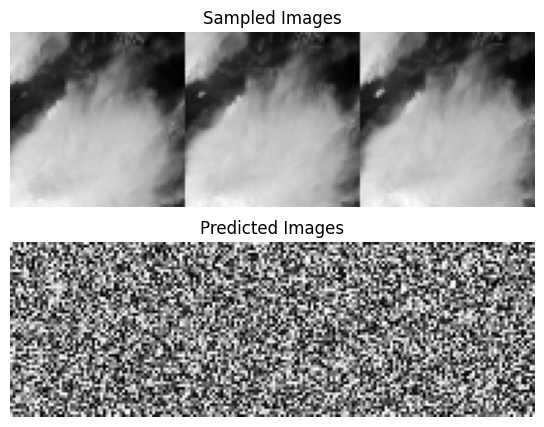

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -1.0 1.0


validation epoch=5, val PSNR=-3.102, val SSIM=0.002, val MSE=0.467, val mCSI=0.740


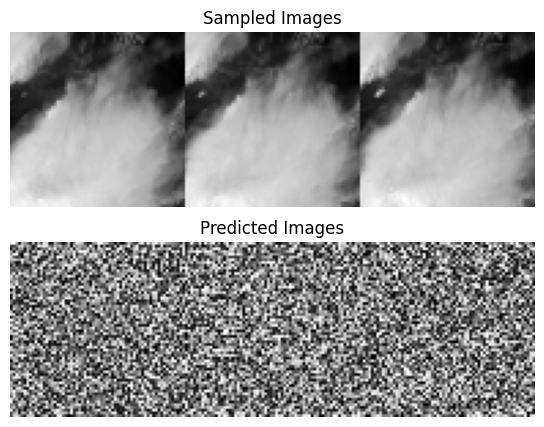

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -1.0 1.0


validation epoch=10, val PSNR=-2.467, val SSIM=0.003, val MSE=0.404, val mCSI=0.743


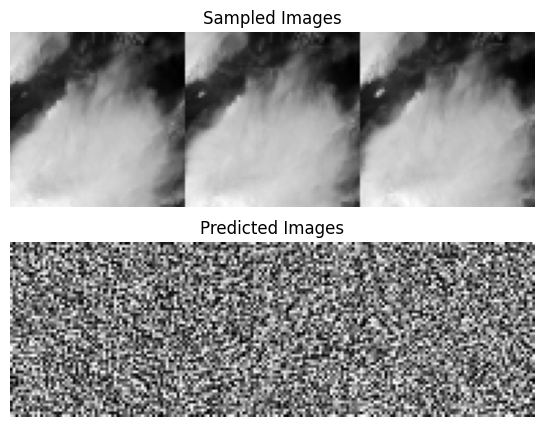

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -1.0 1.0


validation epoch=15, val PSNR=-0.954, val SSIM=0.008, val MSE=0.285, val mCSI=0.747


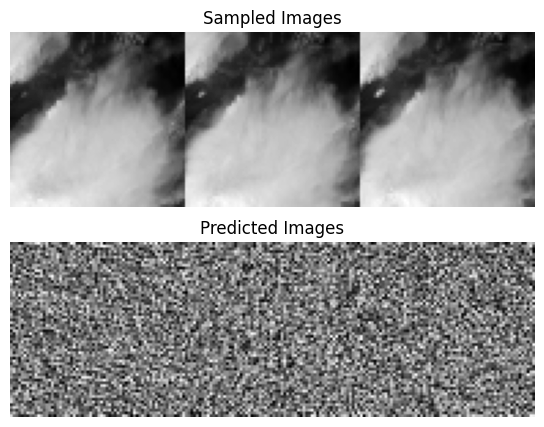

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -1.0 0.99742013


validation epoch=20, val PSNR=2.010, val SSIM=0.034, val MSE=0.144, val mCSI=0.753


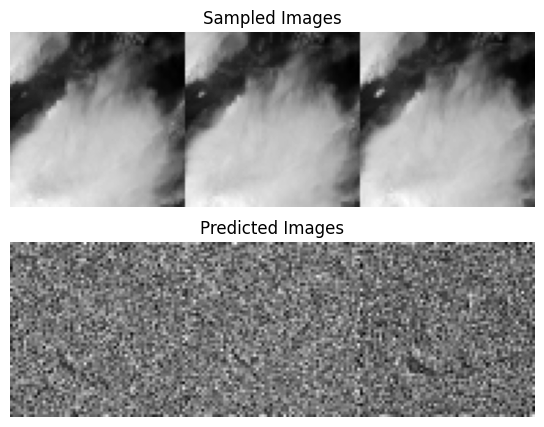

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -1.0 0.946419


validation epoch=25, val PSNR=5.410, val SSIM=0.100, val MSE=0.066, val mCSI=0.757


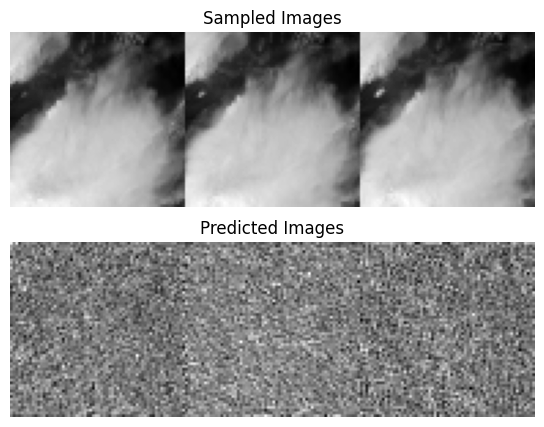

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.8562262 0.5409758


validation epoch=30, val PSNR=7.849, val SSIM=0.190, val MSE=0.038, val mCSI=0.760


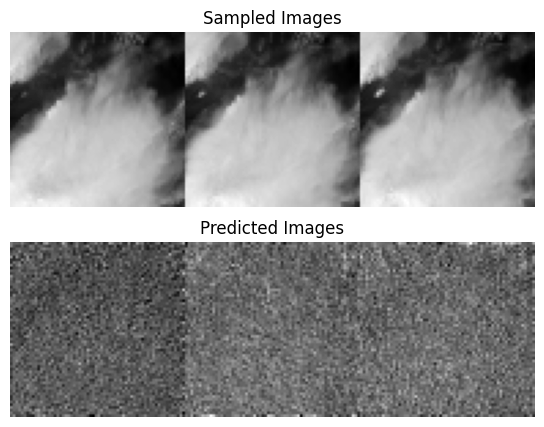

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.6716866 0.3923122


validation epoch=35, val PSNR=10.996, val SSIM=0.285, val MSE=0.018, val mCSI=0.760


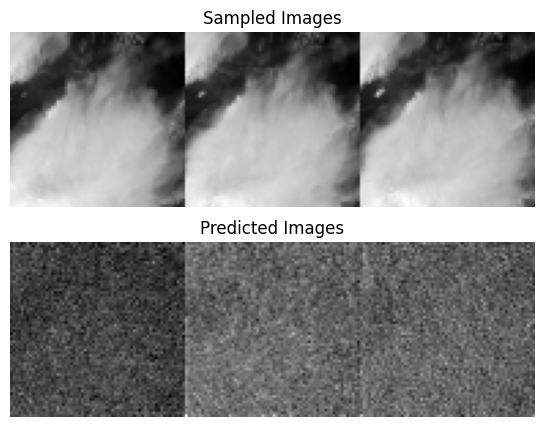

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.6524355 0.390614


validation epoch=40, val PSNR=10.556, val SSIM=0.236, val MSE=0.020, val mCSI=0.764


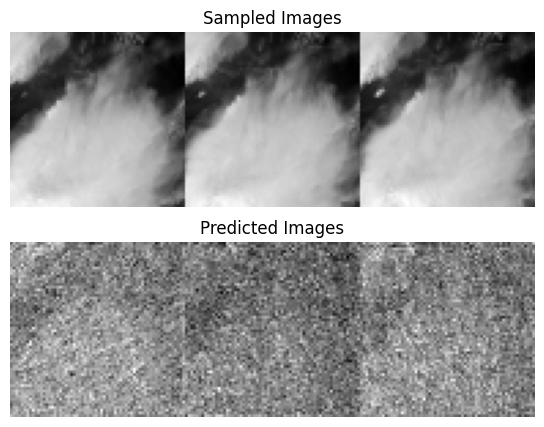

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.54530615 -0.03383379


validation epoch=45, val PSNR=10.006, val SSIM=0.267, val MSE=0.023, val mCSI=0.764


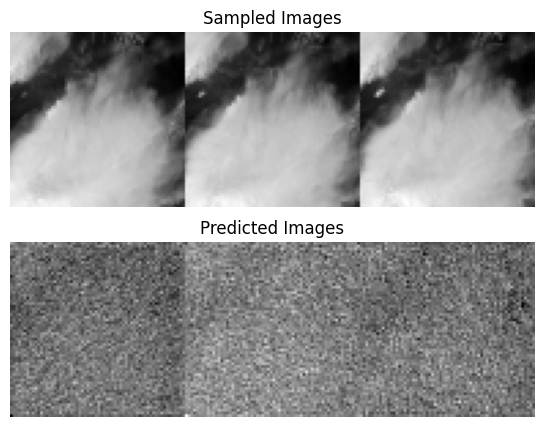

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.6402771 0.21418111


validation epoch=50, val PSNR=10.870, val SSIM=0.322, val MSE=0.019, val mCSI=0.765


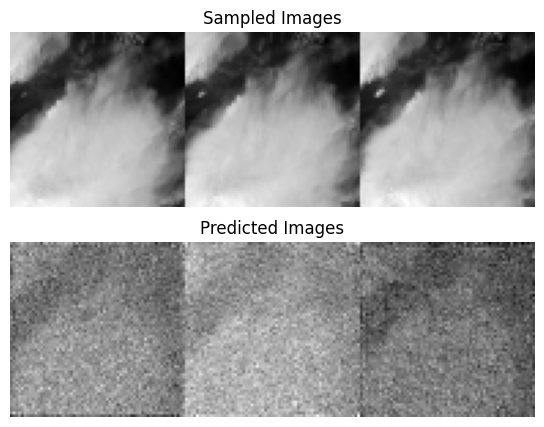

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.5432847 -0.0606119


validation epoch=55, val PSNR=8.633, val SSIM=0.229, val MSE=0.031, val mCSI=0.763


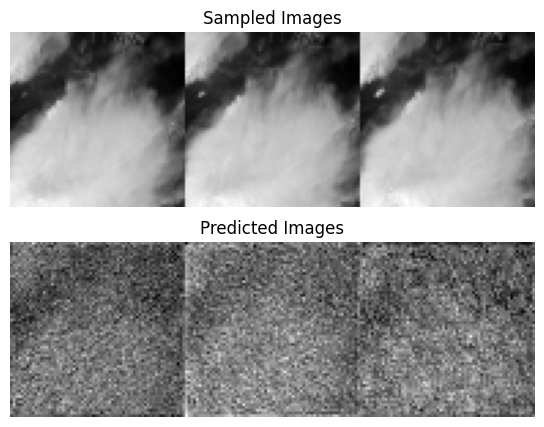

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.4525161 0.009782562


validation epoch=60, val PSNR=6.910, val SSIM=0.148, val MSE=0.047, val mCSI=0.763


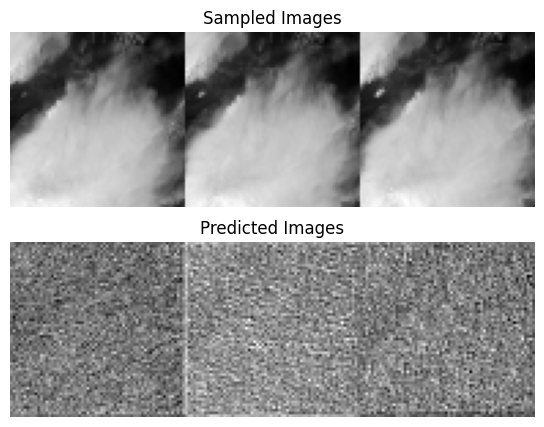

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.6345521 0.3262552


validation epoch=65, val PSNR=7.794, val SSIM=0.194, val MSE=0.038, val mCSI=0.763


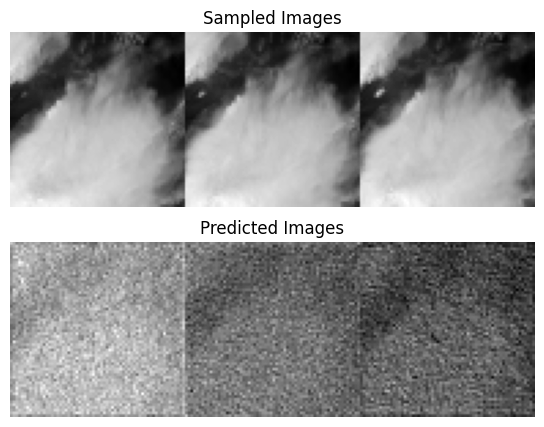

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.5278242 0.07743886


validation epoch=70, val PSNR=7.518, val SSIM=0.253, val MSE=0.041, val mCSI=0.763


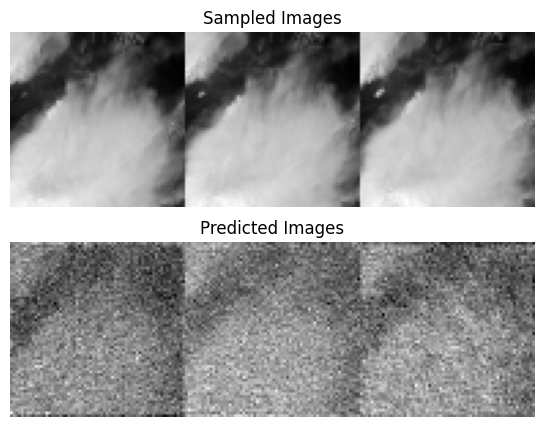

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.42418185 -0.086776786


validation epoch=75, val PSNR=9.058, val SSIM=0.286, val MSE=0.028, val mCSI=0.764


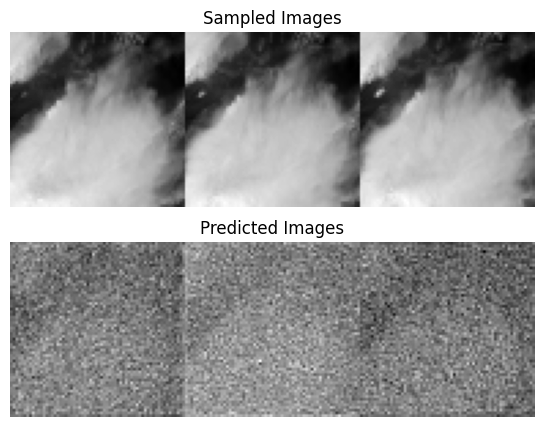

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.5499643 0.13970374


validation epoch=80, val PSNR=9.380, val SSIM=0.352, val MSE=0.026, val mCSI=0.765


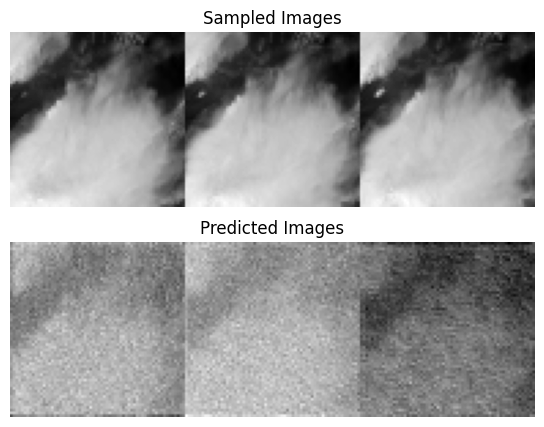

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.51289696 -0.07375446


validation epoch=85, val PSNR=9.589, val SSIM=0.361, val MSE=0.025, val mCSI=0.764


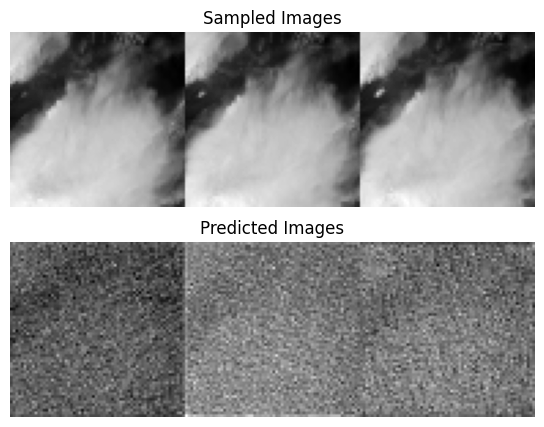

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.5235645 0.25442687


validation epoch=90, val PSNR=9.239, val SSIM=0.275, val MSE=0.027, val mCSI=0.763


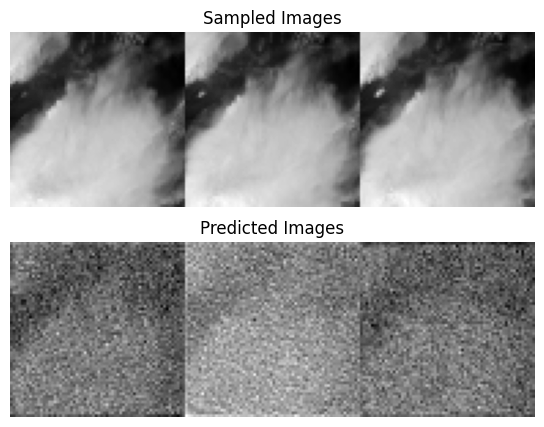

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.4421153 -0.01487972


validation epoch=95, val PSNR=8.131, val SSIM=0.291, val MSE=0.035, val mCSI=0.765


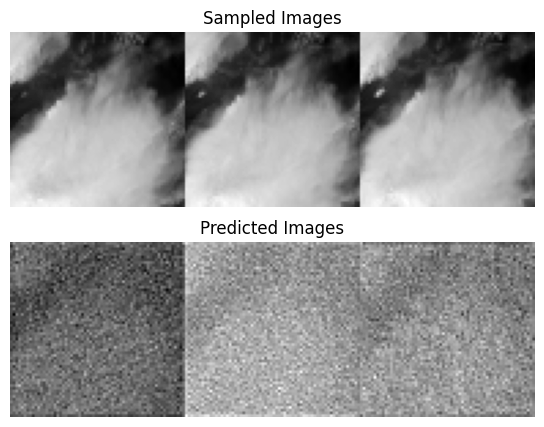

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.5226409 0.082324944


validation epoch=100, val PSNR=10.832, val SSIM=0.517, val MSE=0.019, val mCSI=0.766


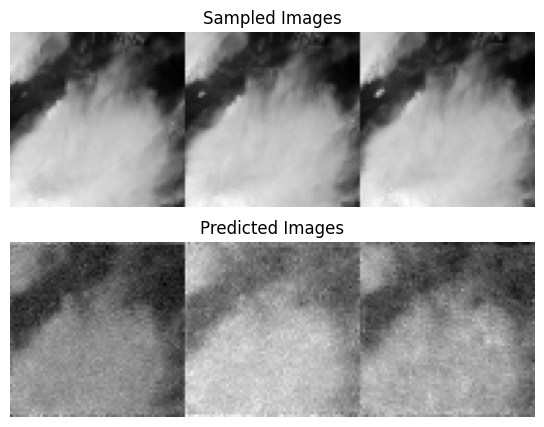

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.43688148 -0.20658772


validation epoch=105, val PSNR=10.053, val SSIM=0.384, val MSE=0.023, val mCSI=0.765


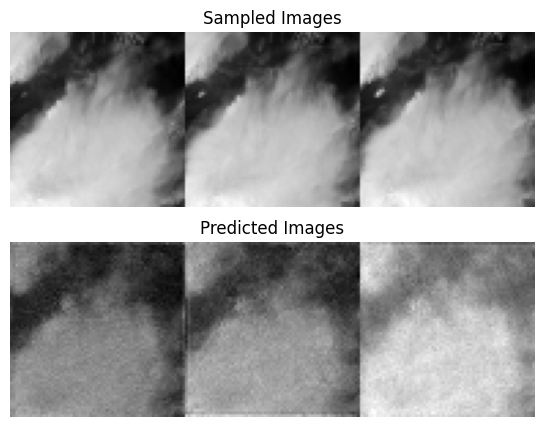

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.45481083 -0.24822146


validation epoch=110, val PSNR=9.932, val SSIM=0.365, val MSE=0.023, val mCSI=0.766


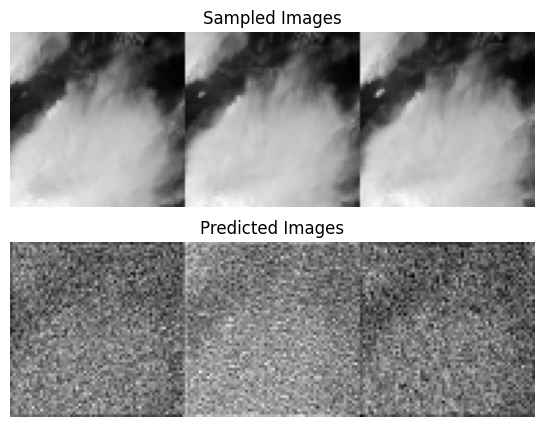

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.44431424 0.08744372


validation epoch=115, val PSNR=8.832, val SSIM=0.389, val MSE=0.030, val mCSI=0.764


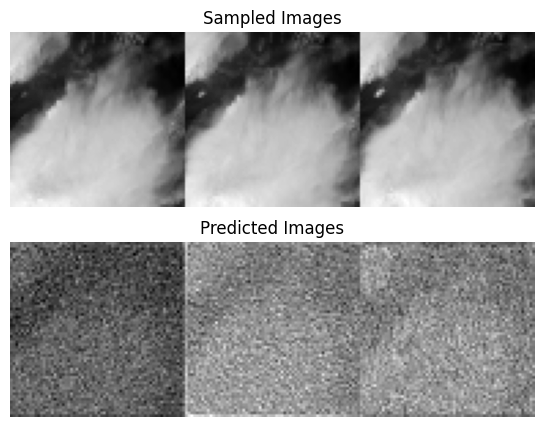

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.48796692 0.11211866


validation epoch=120, val PSNR=8.482, val SSIM=0.380, val MSE=0.032, val mCSI=0.764


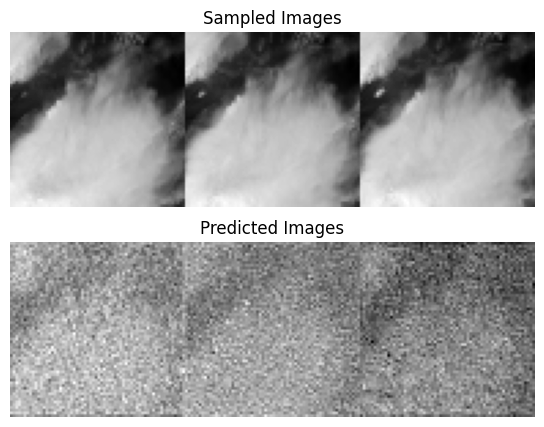

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.47982743 -0.019737635


validation epoch=125, val PSNR=10.503, val SSIM=0.503, val MSE=0.020, val mCSI=0.766


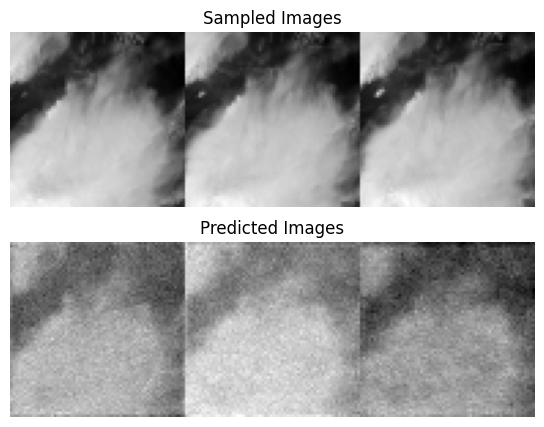

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.4488048 -0.1964814


validation epoch=130, val PSNR=9.921, val SSIM=0.440, val MSE=0.023, val mCSI=0.767


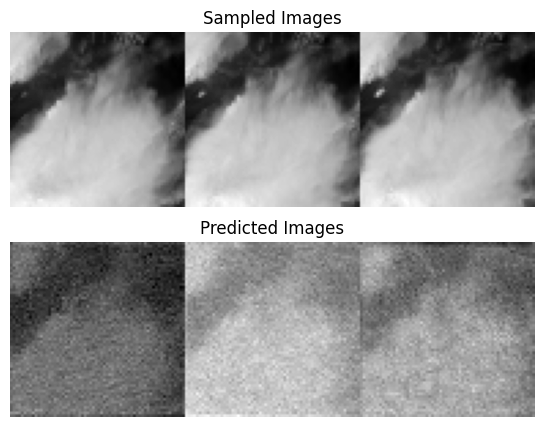

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.4694272 -0.12408831


validation epoch=135, val PSNR=8.651, val SSIM=0.343, val MSE=0.031, val mCSI=0.764


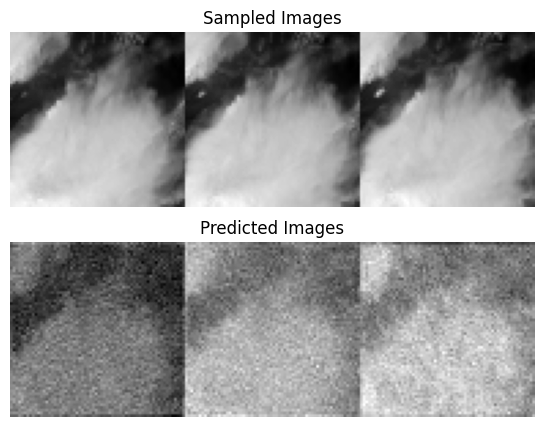

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.42623702 -0.13846159


validation epoch=140, val PSNR=10.318, val SSIM=0.604, val MSE=0.021, val mCSI=0.764


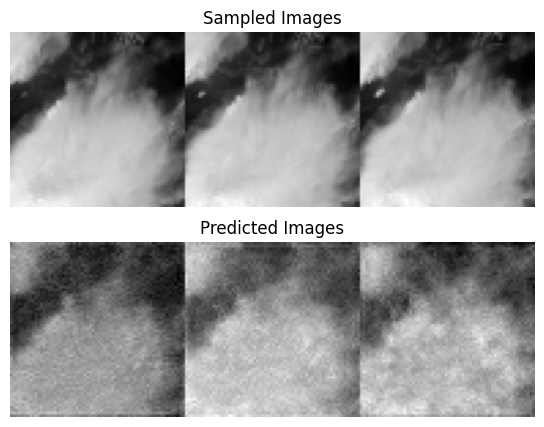

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.4086003 -0.21440668


validation epoch=145, val PSNR=10.133, val SSIM=0.467, val MSE=0.022, val mCSI=0.767


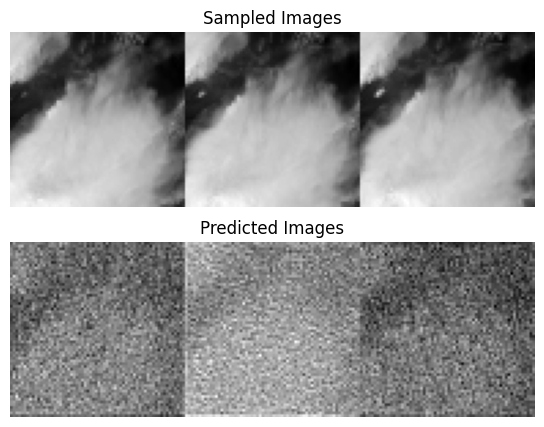

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.44313043 0.06553694


validation epoch=150, val PSNR=9.966, val SSIM=0.473, val MSE=0.023, val mCSI=0.766


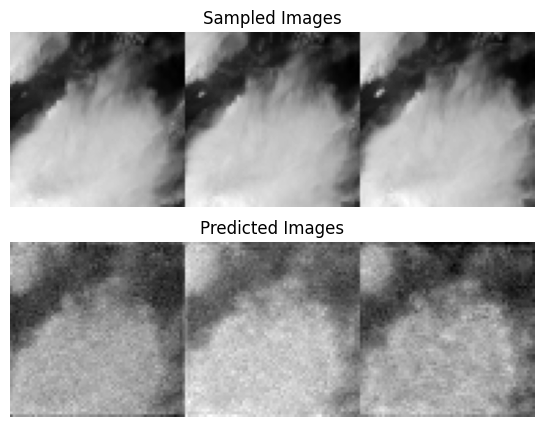

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.4184064 -0.21080172


validation epoch=155, val PSNR=10.817, val SSIM=0.591, val MSE=0.019, val mCSI=0.767


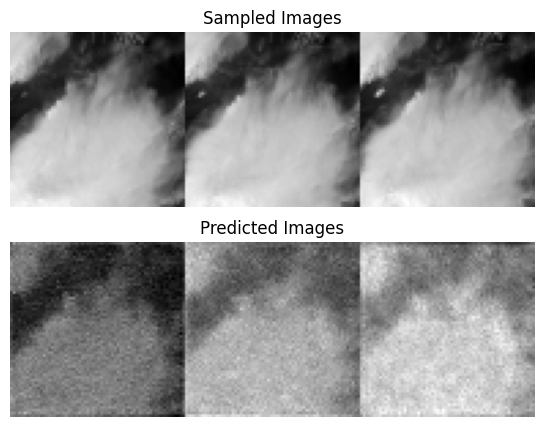

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.4205077 -0.17476048


validation epoch=160, val PSNR=11.989, val SSIM=0.631, val MSE=0.014, val mCSI=0.769


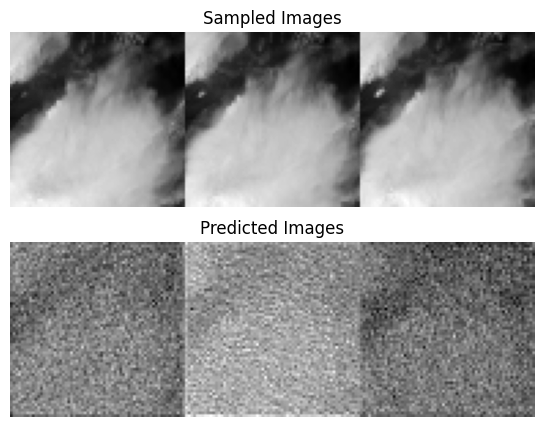

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.494241 0.12060581


validation epoch=165, val PSNR=11.806, val SSIM=0.628, val MSE=0.015, val mCSI=0.766


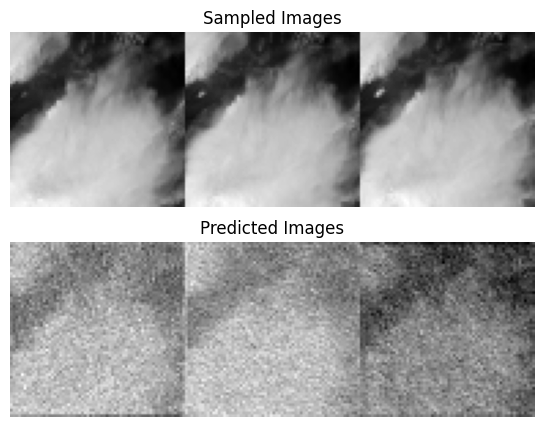

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.44437912 -0.108156


validation epoch=170, val PSNR=10.024, val SSIM=0.502, val MSE=0.023, val mCSI=0.767


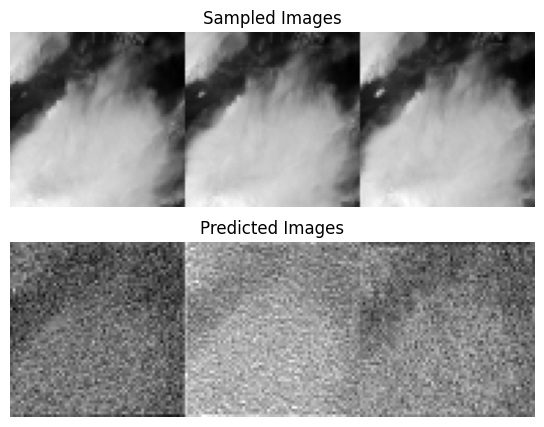

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.45315084 0.016416516


validation epoch=175, val PSNR=10.854, val SSIM=0.504, val MSE=0.019, val mCSI=0.770


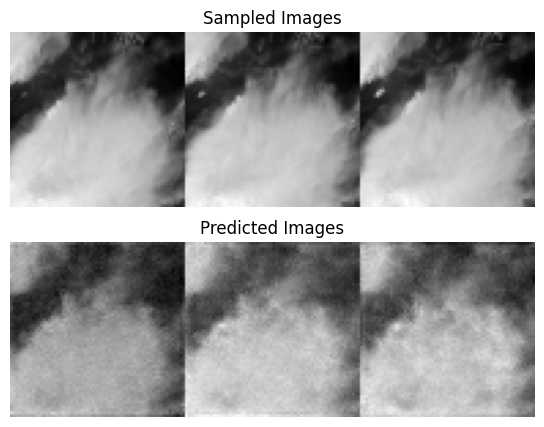

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.4269098 -0.25328246


validation epoch=180, val PSNR=11.982, val SSIM=0.597, val MSE=0.014, val mCSI=0.776


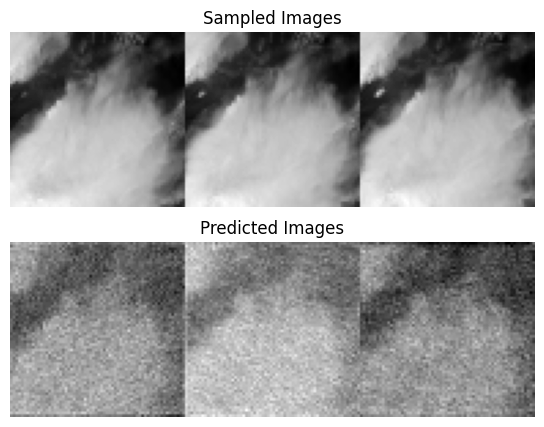

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.42559358 -0.14636117


validation epoch=185, val PSNR=11.126, val SSIM=0.580, val MSE=0.018, val mCSI=0.765


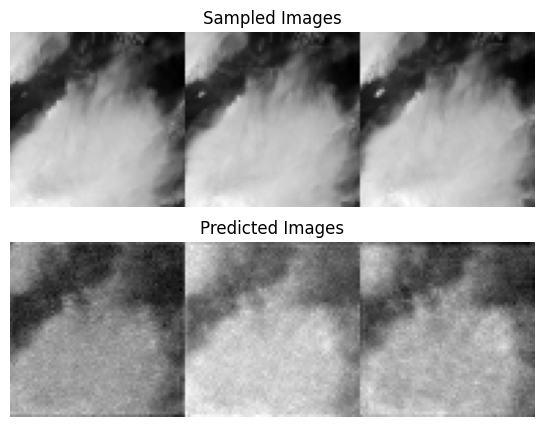

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.42313737 -0.22124161


validation epoch=190, val PSNR=11.039, val SSIM=0.585, val MSE=0.018, val mCSI=0.771


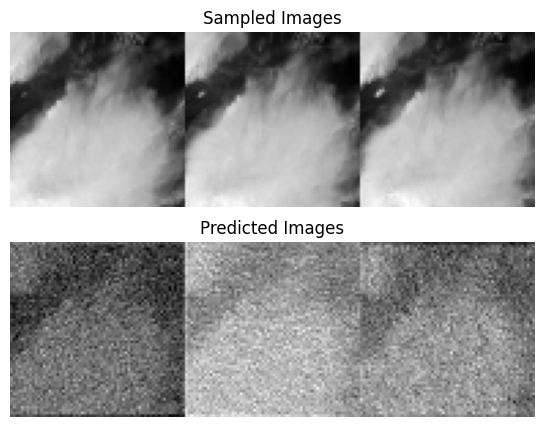

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.42855114 -0.050086126


validation epoch=195, val PSNR=11.623, val SSIM=0.561, val MSE=0.016, val mCSI=0.768


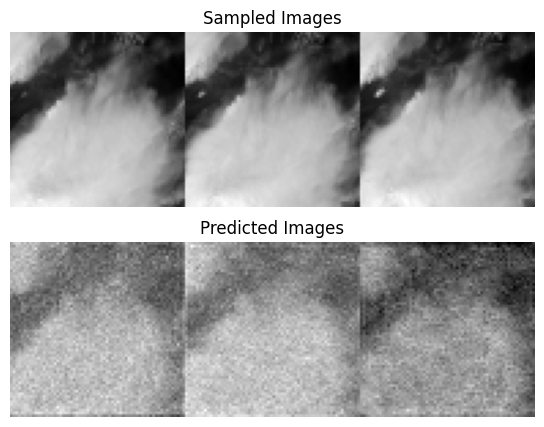

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.4338111 -0.17043276


validation epoch=200, val PSNR=11.592, val SSIM=0.596, val MSE=0.016, val mCSI=0.769


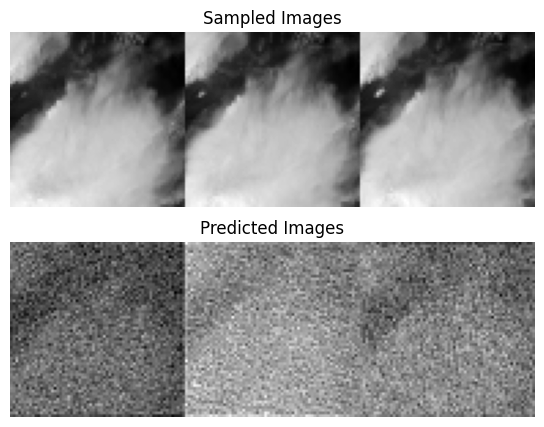

target_frames bounds:  -0.43854612 -0.3134212
predicted_frames bounds:  -0.45171872 0.06037164


In [10]:
# trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)

# Train the model.
with wandb.init(
    project='cloud-diffuser-baseline-no-autoregression',
    entity='ai-industry',
    config=config,
    tags=['ddpm', config.model_name]
    ):        
    histories = trainer.fit(config)

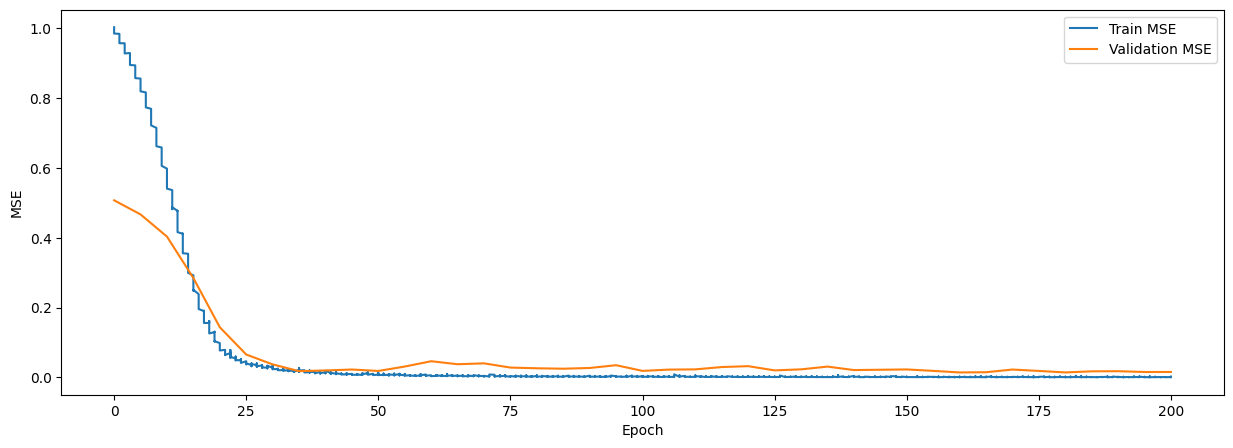

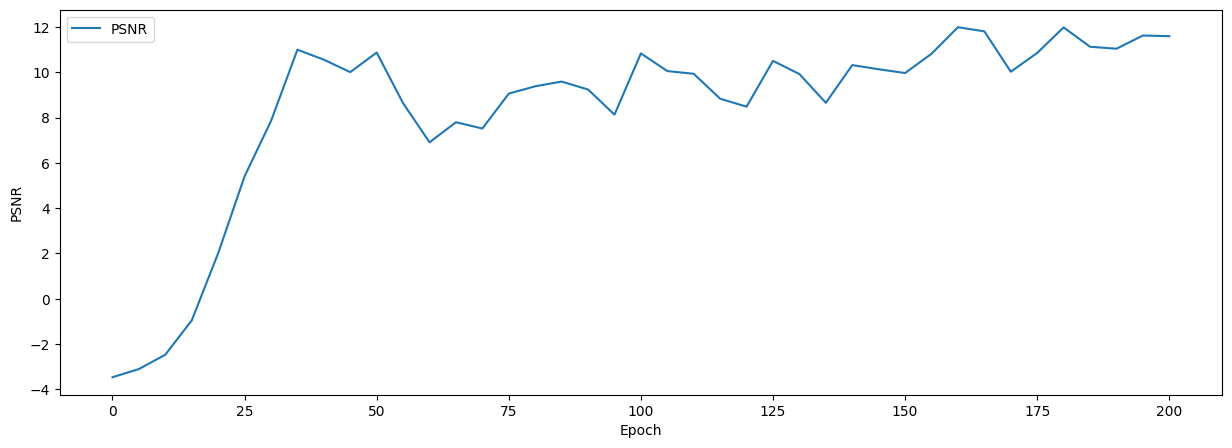

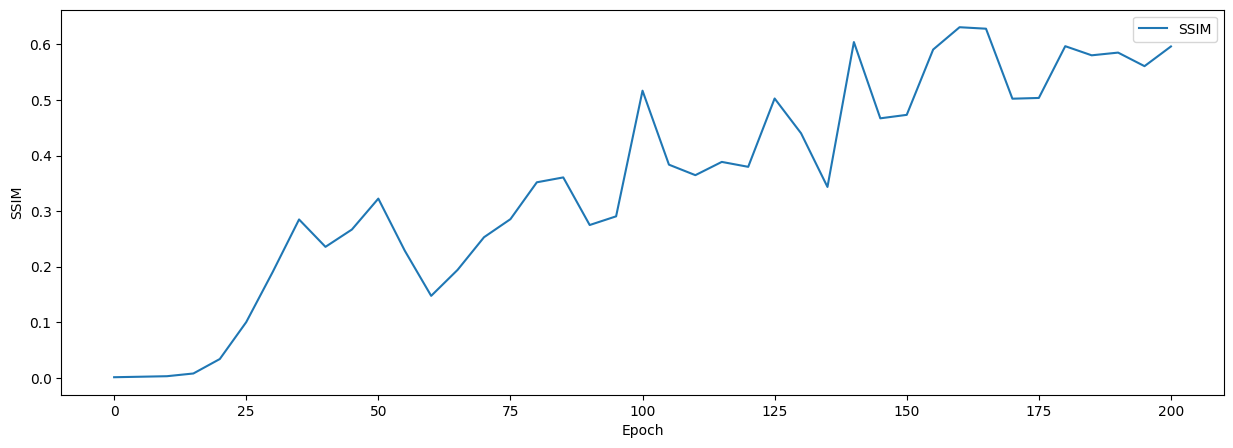

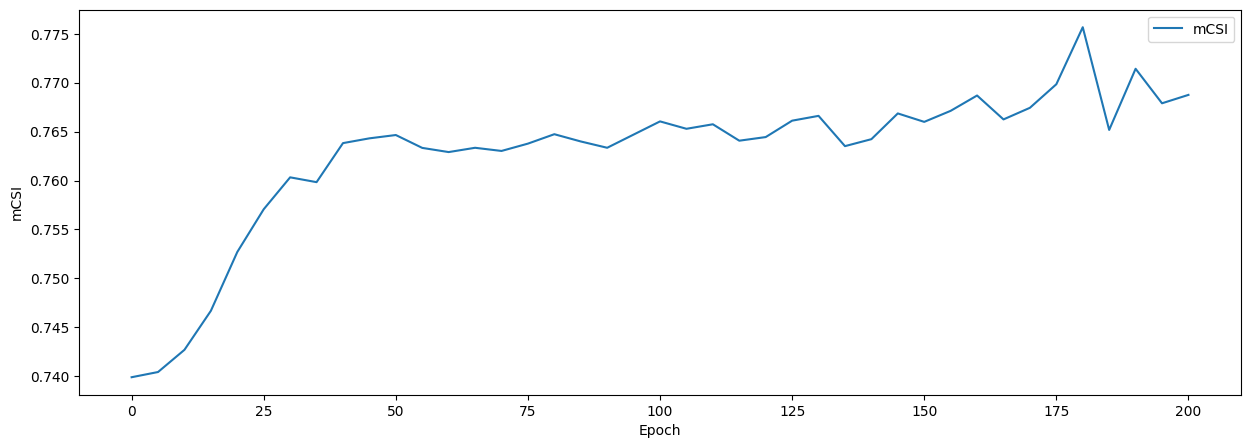

In [11]:
from src.visualization import plot_metrics

plot_metrics(
    *histories[:2],
    PSNR=histories[2],
    SSIM=histories[3],
    mCSI=histories[4])